## Data Scientist Nanodegree
### Vitor Arrais, June 2020

# Project Definition

## Project Overview

This project aims to build a machine learning model that recommends offers to Starbucks customers. 

## Problem Statement

The problem is formulated around a recommendation problem, where Starbucks wants to find the best offers for its costumers. In Starbucks stand point, a good recommendation engine is desirable because it will avoid spamming offers to customer that won't buy them. Additionally, it increases the chance of tailoring good offers to customers with higher chances to buy them. That will potentially increase the offer conversion rate, and lead to a increase in sells too.

## Metrics

All customers will receive a Journey's Score as a indicator of how well an offer fits them. There are three different steps a customer has to advance in order to complete his journey, described as follows:

* **Step 1**: receive an offer
* **Step 2**: view an offer
* **Step 3**: buy an offer  

When a customer goes through all these three steps we say that he has completed his journey, showing us that the offer was successful. The idea here is to know how far a customer can go in the journey - represented by the step he has taken. Therefore, for each step we'll assign a weight, and as the customer advance steps, we add up the weights to the score. In other words, we can say that the Journey's Score is the sum of all weights a customer got from advancing the offer recommendation journey. 

# Analysis 

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Algorithms and Techniques  

The proposed solution will use a FunkSVD model to recommend offers to customers. We aim to build a matrix with the rows as customers and columns as offers, and the cells as the Journey's Score of each customer. The score will indicate how well a offer fits the customer. Below we have the import of dependencies and the import of the datasets.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import random
import matplotlib.pyplot as plt
from datetime import date, datetime
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

Here we gonna take a quick look on the data sets, in particular:
1. head of datasets.   
2. shape of datasets.  
3. number of NaN values.  

### Head of datasets

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Shape of datasets

In [5]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

### Number of NaN values

The portfolio and transcript dataframes are complete, however, the profile dataset has 2175 rows with some NaN value. It's not a big deal because we're going to use a the FunkSVD that will take care of these missing values.

In [6]:
print('Number of NaN values by dataframe')
print('--------------------------------------')
print('Profile dataframe')
print(profile.isna().sum())
print('--------------------------------------')
print('Portfolio dataframe')
print(portfolio.isna().sum())
print('--------------------------------------')
print('Transcript dataframe')
print(transcript.isna().sum())

Number of NaN values by dataframe
--------------------------------------
Profile dataframe
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
--------------------------------------
Portfolio dataframe
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64
--------------------------------------
Transcript dataframe
event     0
person    0
time      0
value     0
dtype: int64


## Data Preprocessing

In order to get the most of our data, and before getting it into our model, we first preprocess to tailor it towards our needs. In particular:

1. treat the data from profile dataset.
2. treat the data from portfolio dataset.
3. treat the data from transcript dataset.
4. put it all together. 

### Treat the data from profile dataset
First we drop the rows with NaN values in gender and income columns. We all create dummies for the categorical columns.

In [7]:
# create a sequential id for customers
profile['customer_id'] = profile.index

# create year and month columns for the date the customer has become a member
profile['entry_year']  = profile['became_member_on'].apply(lambda date: int(str(date)[:4])) 
profile['entry_month'] = profile['became_member_on'].apply(lambda date: int(str(date)[4:6]))

# create a column to indicate how long a customer is a member
lst_months_being_member = []
today_year = datetime.now().year
today_month = datetime.now().month

for i in profile.index.values:
    lst_months_being_member.append((today_year - profile['entry_year'][i] - 1) * 12 + (12 - profile['entry_month'][i]) + today_month)

profile['months_being_member'] = lst_months_being_member

# get dummies from gender and concat with profile
profile = pd.concat([profile, pd.get_dummies(profile['gender'])], axis = 1)
profile.head()    

,age,became_member_on,gender,id,income,customer_id,entry_year,entry_month,months_being_member,F,M,O
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,2017,2,40,0,0,0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,2017,7,35,1,0,0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2,2018,7,23,0,0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,3,2017,5,37,1,0,0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,4,2017,8,34,0,0,0


### Treat the data from portfolio dataset

In [8]:
# create an sequential offer id with prefix
portfolio['offer_id'] = ['offer_' + str(portfolio.index[i]) for i in range (10)]

# get a separate column for each channel type
portfolio['email'] = [1 if 'email' in portfolio['channels'][i] else 0 for i in range(10)]
portfolio['mobile'] =  [1 if 'mobile' in portfolio['channels'][i] else 0 for i in range(10)]
portfolio['social'] = [1 if 'social' in portfolio['channels'][i] else 0 for i in range(10)]
portfolio['web'] = [1 if 'web' in portfolio['channels'][i] else 0 for i in range(10)]
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis = 1)

portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,offer_id,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer_0,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,offer_1,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer_2,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,offer_3,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer_4,1,0,0,1,0,1,0


### Treat the data from transcript dataset
Notice that the **value** column cotains a combination of 'offer id', 'reward' and 'amount'. Then, we'll separate them into different columns. 

In [9]:
def get_dict_values(all_dicts):
    """
    Breaks down the value column in offer_id, reward and amount
    """
    # initialize the list
    lst_values =  [[], [], []]
    for item in all_dicts:
        keys = item.keys()
        
        # getting the offer id. In some cases we have 'offer_id' instead of 'offer id'
        if 'offer id' in keys: lst_values[0].append(item['offer id'])
        else:
            if 'offer_id' in keys: lst_values[0].append(item['offer_id'])
            else: lst_values[0].append(np.nan)
        
        # getting reward
        if 'reward' in keys: lst_values[1].append(item['reward'])
        else: lst_values[1].append(np.nan)
        
        # getting amount
        if 'amount' in keys: lst_values[2].append(item['amount'])
        else: lst_values[2].append(np.nan)
        
        lst_offer = lst_values[0]
        lst_reward = lst_values[1]
        lst_amount = lst_values[2]
        
    
    return lst_offer, lst_reward, lst_amount

# Unzip the columns value to get {offer_id, reward, amount}
transcript['offer'], transcript['reward_received'], transcript['amount'] = get_dict_values (transcript['value'])
transcript = pd.concat([transcript, pd.get_dummies(transcript['event'])], axis = 1)
transcript.head()

,event,person,time,value,offer,reward_received,amount,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


Notice that we have four types of events, and their corresponding value's column:

1. **when event is offer received** the value's column contains offer id   
2. **when event is offer viewed** the value's column contains offer id 
3. **when event is offer completed** the value's column contains offer id and the reward received  
4. **when event is transaction** the value's column contains the transaction amount  

Let's take a look at the NaN values for each type of event [received, viewed, completed, transaction]

In [10]:
lst_events = ['offer received', 'offer viewed', 'offer completed', 'transaction']

print('Null values by event')
print('------------------------------')
for event in lst_events:
    test = transcript[transcript['event'] == event]
    print('Event name:', event)
    print('Nulls offer:', test['offer'].isna().sum())
    print('Nulls reward:', test['reward_received'].isna().sum())
    print('Nulls amount:', test['amount'].isna().sum())
    print('Number of Rows:', test.shape[0])
    print('------------------------------')


Null values by event
------------------------------
Event name: offer received
Nulls offer: 0
Nulls reward: 76277
Nulls amount: 76277
Number of Rows: 76277
------------------------------
Event name: offer viewed
Nulls offer: 0
Nulls reward: 57725
Nulls amount: 57725
Number of Rows: 57725
------------------------------
Event name: offer completed
Nulls offer: 0
Nulls reward: 0
Nulls amount: 33579
Number of Rows: 33579
------------------------------
Event name: transaction
Nulls offer: 138953
Nulls reward: 138953
Nulls amount: 0
Number of Rows: 138953
------------------------------


### Put it all together

Let's concatenate our findings in a single dataframe, which we'll use to feed our machine learning model.

In [11]:
# creates the variable df_central to aggregate all findings from all datasets
df_central = transcript.merge(profile, left_on = 'person', right_on = 'id', how = 'left').drop(['person', 'id'], axis = 1)
df_central = df_central.merge(portfolio, left_on = 'offer', right_on = 'id', how = 'left').drop(['offer', 'id'], axis = 1)

print(df_central.columns.values)
df_central.head()                          

['event' 'time' 'value' 'reward_received' 'amount' 'offer completed'
 'offer received' 'offer viewed' 'transaction' 'age' 'became_member_on'
 'gender' 'income' 'customer_id' 'entry_year' 'entry_month'
 'months_being_member' 'F' 'M' 'O' 'channels' 'difficulty' 'duration'
 'offer_type' 'reward' 'offer_id' 'email' 'mobile' 'social' 'web' 'bogo'
 'discount' 'informational']


,event,time,value,reward_received,amount,offer completed,offer received,offer viewed,transaction,age,...,offer_type,reward,offer_id,email,mobile,social,web,bogo,discount,informational
0,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,0,1,0,0,75,...,bogo,5.0,offer_3,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,offer received,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0,1,0,0,118,...,discount,5.0,offer_4,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,offer received,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,0,1,0,0,68,...,discount,2.0,offer_9,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,offer received,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,0,1,0,0,118,...,discount,2.0,offer_6,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,offer received,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,0,1,0,0,118,...,bogo,10.0,offer_1,1.0,1.0,1.0,1.0,1.0,0.0,0.0


### Compute Total Amount Spent

Create a column amount that represents the total amount spent by the customer.

In [13]:
# Split df_central into df_offer | df_amount 
df_offers = df_central[df_central['event'] != 'transaction'].drop(['amount'], axis = 1)
df_transactions = df_central[df_central['event'] == 'transaction'].groupby('customer_id').agg({'amount':'sum'}).reset_index()

profile = profile.merge(df_transactions, on = 'customer_id', how = 'left')

# some nan values were cretated by last operations, they mean no purchases and can be changed by 0
profile['amount'] = profile['amount'].fillna(0)


### Journey's Score

The events offer received, offer viewed, offer completed suggest a path to follow from receing an offer to actually buing it. Therefore, the journey will represent how far a customer advanced in this path. It is important to understand how offers engage customers, that will be achieved by using a scoring system. The Journeys Score is computed with the following formula:

score = 10 * ((number_received) + (3 x number_viewed) + (5 x number_completed)) / (9 x number_received)

Where: 
(1 x number_received): the weight of received offer. 
(3 x number_viewed): the weight of viewed offer. 
(5 x number_completed): the weight of completed offer. 
(9 x number_received): the total journey's score.

The equation above will be used to tell how engaged a customer was by certain offer. However, the customer can take a shortcut and purchase the offer without viewing it. In that case, the customer's engagement was not influenced by the offer, and it doesn't make sense for us to use the previous equation. For these cases, the score will be computed by the following equation:

score = 10 * ((number_received) + (8 x number_viewed) / (9 x number_received)


In [14]:
# take a look in percentual of offers received that have achieved viewed and completed status.
num_received = df_central[df_central['event'] == 'offer received'].shape[0]
num_viewed = df_central[df_central['event'] == 'offer viewed'].shape[0]
num_completed = df_central[df_central['event'] == 'offer completed'].shape[0]

average_score = (num_viewed + 3 * num_completed) / (num_received * 4)
print(num_received, num_viewed, num_completed)
print('Percentual viewed', np.round(num_viewed/num_received, decimals = 2))
print('Percentual completed', np.round(num_completed/num_received, decimals = 2))


76277 57725 33579
Percentual viewed 0.76
Percentual completed 0.44


### Average the Journey's Score

Next we'll find out the avegare Journey's Score in our dataset.

In [15]:
# organize main informations to calculate the journey's score
dct_agg = {'offer received':'sum', 'offer viewed':'sum', 'offer completed':'sum'}
df_journey = df_offers.groupby(['customer_id',  'offer_id']).agg(dct_agg)

df_journey.head()

offer received  offer viewed  offer completed
customer_id offer_id                                               
0           offer_4                1             1                0
            offer_5                1             1                1
            offer_6                2             2                1
            offer_9                1             1                0
1           offer_2                1             0                0

**Cool!**  
Now, we have a nice dataframe to work with, but there is no journey's score computated yet. Thus, I'll use the concept introduced before to calculate the journey's score for each pair customer - offer in dataframe above. 

In [16]:
def journey_score(n_received, n_viewed, n_completed):
    """
    Calculate de journey score
    """
    score = 0
    
    if n_completed <= n_viewed: score = 10 * (n_received + 3 * n_viewed + 5 * n_completed) / (9 * n_received)
    else: score = 10 * (n_received + 8 * n_viewed)  /  (9 * n_received)
    
    return np.round(score, decimals = 2)

def get_matrix(df):
    """
    Gets the matrix that will feed the machine learning model
    """
    lst_customer = df.index.get_level_values(0).unique()
    lst_offer = df.index.get_level_values(1).sort_values().unique()
    
    dct_score = {}
    
    for offer in lst_offer:
        lst_score = []
        for customer in lst_customer: 
            try:  # the journey was offered to the customer
                lst_score.append(df_journey.loc[customer, offer]['score'])
            except: # the journey was not offered to the customer
                lst_score.append(np.nan)
                continue
       
        dct_score.update({offer : lst_score}) 
                
    return dct_score


In [17]:
# get score's column
df_journey['score'] = [journey_score(df_journey.iloc[i , 0], df_journey.iloc[i , 1], df_journey.iloc[i , 2]) for i in range(df_journey.shape[0])]

df_journey.head()

offer received  offer viewed  offer completed  score
customer_id offer_id                                                      
0           offer_4                1             1                0   4.44
            offer_5                1             1                1  10.00
            offer_6                2             2                1   7.22
            offer_9                1             1                0   4.44
1           offer_2                1             0                0   1.11

In [18]:
print("Average Journey's Score", np.round(df_journey['score'].mean(), decimals = 2))

Average Journey's Score 5.67


### Split train and test datasets

In [19]:
def split_train_test(df):
    """
    Split the dataframe into train and test parts
    """
    df = df.reset_index()
    
    total_size = df.shape[0]
    train_size = int(np.round(0.9998 * total_size))

    #lst_train = list(random.sample(range(total_size), train_size))
    #lst_test = list(set(range(63288)) - set(lst_train))
    
    lst_test = [12160, 15115, 21513, 25679, 27025, 29832, 33259, 37411, 39761, 44953, 45666, 50143, 50564]
    lst_train = list(set(range(63288)) - set(lst_test))
    
    df_train = df.loc[lst_train].groupby(['customer_id', 'offer_id']).max()
    df_test = df.loc[lst_test].groupby(['customer_id', 'offer_id']).max()

    return df_train, df_test

# split the df_journey in train and test
df_journey_train, df_journey_test = split_train_test(df_journey)

print (df_journey_train.shape, df_journey_test.shape)

# df_matrix is a dataframe where rows mean customer_id and columns mean offer_id
df_matrix = pd.DataFrame.from_dict(get_matrix(df_journey_train))

df_matrix.head()

(63275, 4) (13, 4)


,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,NaN,NaN,NaN,NaN,4.44,10.0,7.22,NaN,NaN,4.44
1,NaN,NaN,1.11,1.11,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,4.44,NaN,NaN,NaN,4.44,NaN,NaN
3,10.0,NaN,NaN,10.00,NaN,NaN,NaN,4.44,10.0,NaN
4,NaN,NaN,4.44,NaN,3.33,NaN,NaN,1.11,NaN,NaN


In [20]:
df_matrix.isna().sum()

offer_0    10620
offer_1    10664
offer_2    10663
offer_3    10639
offer_4    10620
offer_5    10669
offer_6    10662
offer_7    10674
offer_8    10732
offer_9    10709
dtype: int64

## FunkSVD Algorithm

Notice that the dataset is sparse because it has many NaN values. There are more than 10k NaN values in each column. It suggests that we use the FunkSVD algorithm, which was created to deal with such kind of problems.

In [21]:
def FunkSVD(matrix, learning_rate = 0.0005, latent_features = 10, iters = 500):
    """
    Funk SVD algorithm 
    >>> ARGS:
        matrix - np.arrays containing the journey's score (rows == customers_id, columns == offer_id)
        learning_rate - the step's size for each interation
        latent_features: the number of latent_features that will be used
        iters: number of interations
    <<< RETURN:
        matrix customer: matrix customer X latent feature
        matrix offer - matrix latent feature X offer
    """
    
    # control variables
    n_customer = matrix.shape[0]
    n_offer = matrix.shape[1]
    n_journey = np.count_nonzero(~np.isnan(matrix))
    
    # first guess
    matrix_customer = np.random.randn(n_customer, latent_features)
    matrix_offer = np.random.randn(latent_features, n_offer)
    
    
    plot_iteration = []
    plot_sse = []
    
    
    # FunkSVD algorithm
    sse_accum = 0 
    for iteration in range(iters):
        
        # renew the sum of squared error (sse)
        old_sse = sse_accum
        sse_accum = 0 
        
        for customer in range(n_customer):
            for offer in range(n_offer):
                if not np.isnan(matrix[customer, offer]):
                    
                    
                    diff = matrix[customer, offer] - np.dot(matrix_customer[customer, :], matrix_offer[:, offer]) 
                    
                    # calculate the new sse_accum
                    
                    sse_accum += diff ** 2
                    for k in range(latent_features):
                        
                        # change the old guess for the new one
                        matrix_customer[customer, k] += learning_rate * (2 * diff * matrix_offer[k, offer])
                        matrix_offer[k, offer] += learning_rate * (2 * diff * matrix_customer[customer, k])
        
        #if iteration % 10 == 0:
        plot_iteration.append(iteration)
        plot_sse.append(np.round(sse_accum / n_journey, decimals = 2))
    
    plt.plot(plot_iteration, plot_sse);
    plt.grid(linestyle='--')
    plt.xlabel('Interaction');
    plt.ylabel('Mean Squared Error');
    plt.title('Mean Squared Error vs. Interaction');
    
    return matrix_customer, matrix_offer, np.round(sse_accum / n_journey, decimals = 2)

def comparison(matrix_predict, df_test):
    import math
    dct_offer = {
        'offer_0': 0, 'offer_1': 1, 'offer_2': 2, 'offer_3': 3, 'offer_4': 4,
        'offer_5': 5, 'offer_6': 6, 'offer_7': 7, 'offer_8': 8, 'offer_9': 9,
    }
    
    lst_customer_compare = df_test.index.get_level_values(0).unique()
    
    print(f'{"Customer id":<15}{"Offer id":<15}{"Real Score":<15}{"Predicted Score"}')
    
    error = 0
    cter = 0
    error_average = 0
    
    for customer in lst_customer_compare:
        for offer in df_test.loc[customer].index:
            score_real = df_journey_test.loc[customer, offer]['score']
            score_pred = np.round(matrix_predict[customer][dct_offer[offer]], decimals = 2)
            
            print(f'{customer:<15}{offer:<15}{score_real:<15}{score_pred:.2f}')

## Model Evaluation and Validation

Now, the main part of recommendation engine is designed. Next we will evaluate how good is the model using the mean squared error. The model will predict the Journey's Score for customers in the test data set. 

### First Attempt

We're going to Keep the **learning rate** and **number of iterations** constant while we increase the number of **latent features** and see how they affect our results.

#### 10 Latent Features

Mean Squared Error 5.1
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           11.00
4059           offer_2        4.44           3.53
5783           offer_8        10.0           6.65
6895           offer_2        4.44           3.49
7258           offer_9        1.11           4.43
8000           offer_6        10.0           5.58
8913           offer_8        10.0           6.94
10032          offer_2        2.78           2.99
10656          offer_0        4.44           5.02
12047          offer_4        1.11           2.31
12236          offer_0        4.44           6.36
13445          offer_1        10.0           6.73
13554          offer_8        1.11           4.09


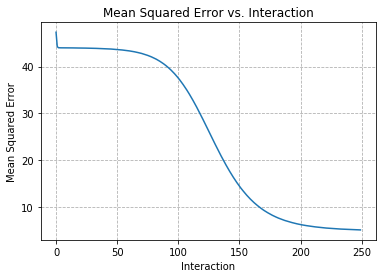

In [148]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0001, latent_features = 10, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### 20 Latent Features 

Mean Squared Error 4.94
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.92
4059           offer_2        4.44           3.76
5783           offer_8        10.0           6.55
6895           offer_2        4.44           3.62
7258           offer_9        1.11           5.90
8000           offer_6        10.0           6.10
8913           offer_8        10.0           6.65
10032          offer_2        2.78           2.50
10656          offer_0        4.44           4.60
12047          offer_4        1.11           1.57
12236          offer_0        4.44           5.96
13445          offer_1        10.0           8.12
13554          offer_8        1.11           3.32


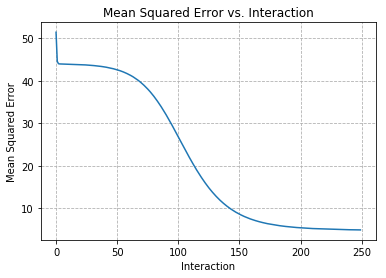

In [149]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0001, latent_features = 20, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### 30 Latent Features

Mean Squared Error 4.89
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           11.18
4059           offer_2        4.44           3.57
5783           offer_8        10.0           6.26
6895           offer_2        4.44           3.23
7258           offer_9        1.11           6.53
8000           offer_6        10.0           4.92
8913           offer_8        10.0           6.87
10032          offer_2        2.78           3.30
10656          offer_0        4.44           5.53
12047          offer_4        1.11           2.25
12236          offer_0        4.44           5.65
13445          offer_1        10.0           10.53
13554          offer_8        1.11           3.95


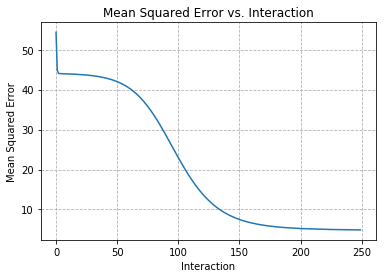

In [150]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0001, latent_features = 30, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### 50 Latent Features

Mean Squared Error 4.86
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.26
4059           offer_2        4.44           4.15
5783           offer_8        10.0           7.47
6895           offer_2        4.44           3.58
7258           offer_9        1.11           5.11
8000           offer_6        10.0           5.31
8913           offer_8        10.0           6.97
10032          offer_2        2.78           2.59
10656          offer_0        4.44           4.30
12047          offer_4        1.11           2.56
12236          offer_0        4.44           5.84
13445          offer_1        10.0           8.84
13554          offer_8        1.11           4.10


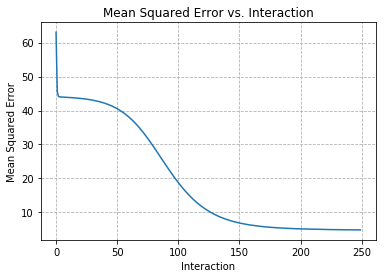

In [151]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0001, latent_features = 50, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### 100 Latent Features

Mean Squared Error 4.71
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           11.34
4059           offer_2        4.44           3.99
5783           offer_8        10.0           6.60
6895           offer_2        4.44           3.18
7258           offer_9        1.11           5.06
8000           offer_6        10.0           5.45
8913           offer_8        10.0           6.60
10032          offer_2        2.78           3.33
10656          offer_0        4.44           5.58
12047          offer_4        1.11           2.92
12236          offer_0        4.44           4.30
13445          offer_1        10.0           8.26
13554          offer_8        1.11           4.44


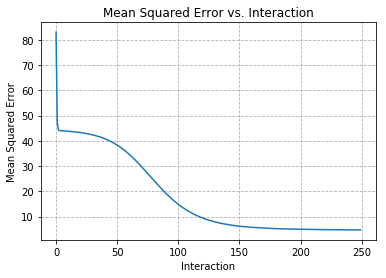

In [152]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0001, latent_features = 100, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

Notice that the mean square error remains constant as we increase the number of latent features, however, it converges faster for higher number of latent features. 

### Second Attempt
Now we're going to keep the number of **latent features** and number of iteractions constant while we increase the **learning rate**.

#### Learning Rate 0.005

In [155]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.005, latent_features = 100, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars


KeyboardInterrupt: 

Here we can see that a learning rate as high as 0.005 throws a python error. Then, we're going to start with a considerably lower number.

#### Learning Rate 0.0003

Mean Squared Error 3.76
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           11.40
4059           offer_2        4.44           2.95
5783           offer_8        10.0           7.23
6895           offer_2        4.44           3.00
7258           offer_9        1.11           3.99
8000           offer_6        10.0           5.27
8913           offer_8        10.0           7.32
10032          offer_2        2.78           3.64
10656          offer_0        4.44           2.97
12047          offer_4        1.11           3.48
12236          offer_0        4.44           7.11
13445          offer_1        10.0           9.79
13554          offer_8        1.11           4.74


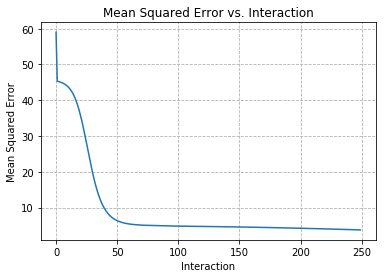

In [156]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0003, latent_features = 100, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### Learning Rate 0.0005

Mean Squared Error 1.91
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.45
4059           offer_2        4.44           3.65
5783           offer_8        10.0           10.80
6895           offer_2        4.44           2.87
7258           offer_9        1.11           2.97
8000           offer_6        10.0           8.44
8913           offer_8        10.0           8.76
10032          offer_2        2.78           3.21
10656          offer_0        4.44           9.86
12047          offer_4        1.11           1.18
12236          offer_0        4.44           1.99
13445          offer_1        10.0           8.39
13554          offer_8        1.11           4.92


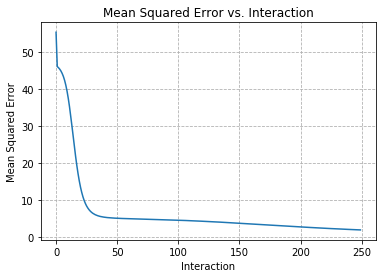

In [157]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0005, latent_features = 100, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### Learning Rate 0.0008

Mean Squared Error 0.84
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.24
4059           offer_2        4.44           3.96
5783           offer_8        10.0           7.10
6895           offer_2        4.44           3.34
7258           offer_9        1.11           1.25
8000           offer_6        10.0           2.73
8913           offer_8        10.0           3.56
10032          offer_2        2.78           4.28
10656          offer_0        4.44           10.51
12047          offer_4        1.11           2.16
12236          offer_0        4.44           5.99
13445          offer_1        10.0           13.81
13554          offer_8        1.11           3.94


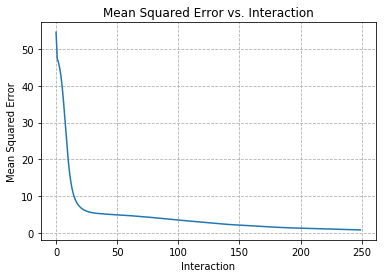

In [158]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0008, latent_features = 100, iters = 250)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

Notice that we've got a way better mean squared error, as good as 0.84 when we used a learning rate of 0.0008 !

### Third Attempt

We're going to keep the **latent features** and **learning rate** constant while we increase the number of **iterations**.

#### 500 Iterations

Mean Squared Error 0.48
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.44
4059           offer_2        4.44           5.70
5783           offer_8        10.0           9.37
6895           offer_2        4.44           4.25
7258           offer_9        1.11           5.79
8000           offer_6        10.0           9.57
8913           offer_8        10.0           8.71
10032          offer_2        2.78           3.97
10656          offer_0        4.44           12.37
12047          offer_4        1.11           4.86
12236          offer_0        4.44           0.29
13445          offer_1        10.0           13.35
13554          offer_8        1.11           5.38


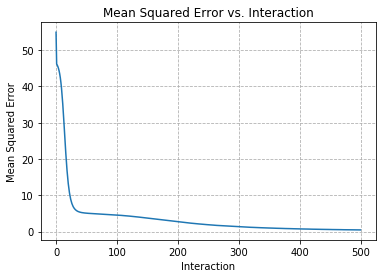

In [159]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0005, latent_features = 100, iters = 500)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

#### 700 iterations

Mean Squared Error 0.21
Customer id    Offer id       Real Score     Predicted Score
3271           offer_5        4.44           10.39
4059           offer_2        4.44           0.69
5783           offer_8        10.0           2.70
6895           offer_2        4.44           4.34
7258           offer_9        1.11           -1.34
8000           offer_6        10.0           8.01
8913           offer_8        10.0           1.52
10032          offer_2        2.78           4.63
10656          offer_0        4.44           3.93
12047          offer_4        1.11           4.28
12236          offer_0        4.44           1.63
13445          offer_1        10.0           11.67
13554          offer_8        1.11           4.90


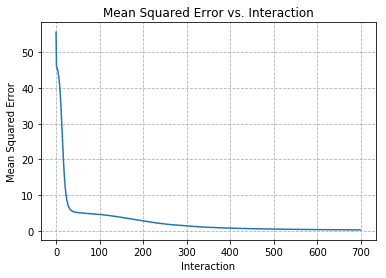

In [160]:
matrix_customer, matrix_offer, mean_sqrt_erro = FunkSVD(df_matrix.values, learning_rate = 0.0005, latent_features = 100, iters = 700)
print('Mean Squared Error', mean_sqrt_erro)

matrix_predict = np.dot(matrix_customer, matrix_offer)
comparison(matrix_predict, df_journey_test)

Notice that after 600 iterations the mean square error is almost zero, awesome results!

## Recommendation Results

Now that we have our model, we will look how its perfomance for a random customer. We took the customer 1500 as example.

In [42]:
cust = 1500
print(df_matrix.loc[cust].values)
print(np.round(matrix_predict[cust], decimals = 2))

[   nan  10.      nan    nan  10.      nan    nan   4.44  10.      nan]
[  8.54  11.27   3.91   5.04   9.38   8.64   9.99   4.5   10.35   8.07]


We can see that the predicted values are pretty close to the actual values. That makes us believe that the prediction for NaN values are accurate as well.

Finally, we need to decice which offers we're going to recommend to user 1500. Here, we will recommend offers where the journey's score is above the dataset mean (5.67). 

In [56]:
def recommend(customer_id, average_score, matrix_predict = matrix_predict):
    
    lst_to_recommend = []
    for i, score in enumerate(matrix_predict[customer_id]):
        if score > average_score: 
            lst_to_recommend.append('offer_' + str(i))
            
    return lst_to_recommend

print("To customer 1500, we recommend the following offers: ", recommend(1500, 5.67))

To customer 1500, we recommend the following offers:  ['offer_0', 'offer_1', 'offer_4', 'offer_5', 'offer_6', 'offer_8', 'offer_9']


### References
Introduction to ML  https://medium.com/towards-artificial-intelligence/machine-learning-algorithms-for-beginners-with-python-code-examples-ml-19c6afd60daa

FunkSVD  
https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac  
https://www.youtube.com/watch?v=ZspR5PZemcs

Fraud detection  
https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [ ]:
Premissa - estudar como escrever caso 1/2/1